In [2]:
import numpy as np
from data import import_images
from cellmask_model import CellMaskModel
import os
import torch
import cv2
import numpy.ma as ma
import matplotlib.pyplot as plt

c:\Users\rz200\AppData\Local\anaconda3\envs\cellprob\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
    def get_encodings(images, model):
        #get the encoder of the model
        encoder = model.unet_cp.encoder
        #torch.from_numpy(encFeats[0]).expand(0).expand(0
        encFeats = encoder(torch.from_numpy(images).unsqueeze(1).type(torch.float32))[2].detach().numpy()

       
        encFeats_interpolated = []
        for i in range(len(encFeats)):
            encFeats_per_channel = []
            for j in range(len(encFeats[i])):
                encFeats_per_channel.append(cv2.resize(encFeats[i][j], (1080,1080), interpolation=cv2.INTER_CUBIC))
            encFeats_interpolated.append(encFeats_per_channel)
        encFeats = np.array(encFeats_interpolated)
        return encFeats  
   
    def get_encFeats_per_cell_per_mask(instance_masks, encFeats):
        encFeats_per_cell_per_mask = []
        for i in range(len(instance_masks)):
            instance_mask = instance_masks[i]
            encoding_features = encFeats[i]
            encoding_features_per_cell_2 = []
            for mask_val in range(1, np.max(instance_mask)+1):
                mask = instance_mask == mask_val
                masked_encFeats = encoding_features[:, mask]
                encoding_features_per_cell_2.append(masked_encFeats)
            encFeats_per_cell_per_mask.append(encoding_features_per_cell_2)#
    
        encFeats_per_cell_per_mask = np.array(encFeats_per_cell_per_mask)
        return encFeats_per_cell_per_mask
   
    def get_pairs(encFeats_per_cell_per_mask):
        cos_sims_for_each_cell = []
        for cell_encFeats in encFeats_per_cell_per_mask[0]:
            cos_sims_for_cell = []
            arr1 = cell_encFeats.flatten()
            for cell_encFeats2 in encFeats_per_cell_per_mask[1]:
                arr2 = cell_encFeats2.flatten()
                if arr1.shape[0] > arr2.shape[0]:
                    arr2 = np.pad(arr2, (0, arr1.shape[0] - arr2.shape[0]), 'constant')
                elif arr1.shape[0] < arr2.shape[0]:
                    arr1 = np.pad(arr1, (0, arr2.shape[0] - arr1.shape[0]), 'constant')
                cos_sim = np.dot(arr1, arr2) / (np.linalg.norm(arr1) * np.linalg.norm(arr2))
                cos_sims_for_cell.append(cos_sim)
            cos_sims_for_each_cell.append(cos_sims_for_cell)

        cos_sims_for_each_cell = np.array(cos_sims_for_each_cell)

        lst = cos_sims_for_each_cell.tolist()

        pairs = []
        length = min(len(lst),len(lst[0]))
        for i in range(length):
            lst = np.array(lst)
            max_index = np.argmax(lst)
            row, col = np.unravel_index(max_index, lst.shape)
            pairs.append((row,col))
            lst[:,col] = 0
            lst[row,:] = 0
        return pairs

    def merge(arr,arr1):
        result = []
        for i in arr:
            for j in arr1:
                if i[-1] == j[0]:
                    res = [num for num in i]
                    res.append(j[1])
                    result.append(res)
        result = np.array(result)
        return result

    def merge_list(list_of_pairs):
        matches = list_of_pairs[0]
        for i in range(len(list_of_pairs)-1):
            matches = merge(matches,list_of_pairs[i+1])
        matches = np.array(matches)
        return np.squeeze(matches)

In [4]:
#import the images#
images = np.array(import_images('images/',num_imgs=3,normalisation=True))

model = CellMaskModel()
model.import_model(os.getcwd() + '/saved_weights/cp_model', os.getcwd() + '/saved_weights/mask_model')
instance_masks, masks, cps = model.eval(images) #Making predictions

In [52]:
encoder = model.unet_cp.encoder
#torch.from_numpy(encFeats[0]).expand(0).expand(0
encFeats_16 = encoder(torch.from_numpy(images).unsqueeze(1).type(torch.float32))[0].detach().numpy()
encFeats_32 = encoder(torch.from_numpy(images).unsqueeze(1).type(torch.float32))[1].detach().numpy()
encFeats_64 = encoder(torch.from_numpy(images).unsqueeze(1).type(torch.float32))[2].detach().numpy()


In [59]:
print(len(encFeats_16))
print(encFeats_16[0][1].shape)
print(encFeats_32[0][1].shape)
print(encFeats_64[0][1].shape)


24
(1080, 1080)
(540, 540)
(270, 270)


In [83]:
for i in range(len(encFeats_32[0])):
    #apply a perspective transform to the image to make them look stacked
    image = encFeats_32[0][i]
    filename = os.path.join('saved_32', f'image_{i}.png')
    plt.imsave(filename, image)

In [85]:
print(len(encFeats_32[0]))

32


In [82]:
for i in range(len(encFeats_16[0])):
    #apply a perspective transform to the image to make them look stacked
    image = encFeats_16[0][i]
    filename = os.path.join('saved_16', f'image_{i}.png')
    plt.imsave(filename, image)

In [76]:
from PIL import Image

# Define the size of the output image
width = 1080 * 1080
height = 1080

# Create a new empty image for the output
output_arr = np.zeros((height, width), dtype=np.uint8)

# Load each image and paste it onto the output image, with a different horizontal offset for each one
for i in range(16):
    img_arr = encFeats_16[0][0] # Change this to the actual file names of your image arrays
    offset = i * 1080
    output_arr[:, offset:offset+1080] = img_arr

# Convert the numpy array to a PIL image
output_img = Image.fromarray(output_arr)

# Apply a perspective transformation to the output image
perspective_coeffs = [1, 0, 0, -0.0005, 1, 0, 0, 0, 1] # Tweak these coefficients to adjust the perspective effect
output_img = output_img.transform((width, height), Image.PERSPECTIVE, perspective_coeffs, Image.BICUBIC)


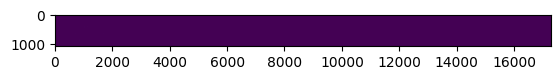

In [72]:
plt.imshow(output_img)

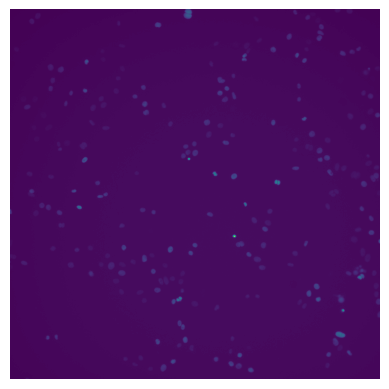

In [50]:
plt.imshow(images[0])
plt.axis('off')
plt.show()

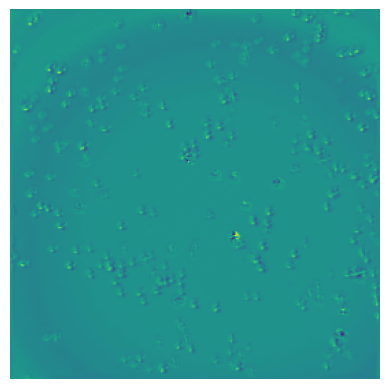

In [49]:
plt.imshow(encFeats[0][0])
plt.axis('off')
plt.show()

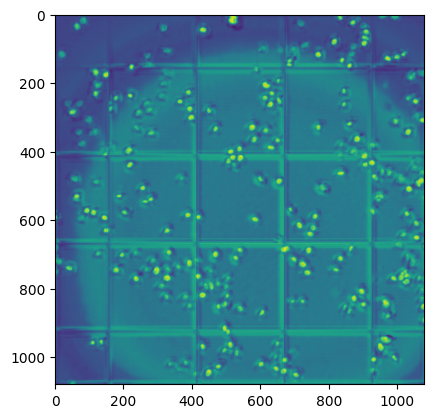

In [5]:
plt.imshow(cps[0])

In [6]:
encFeats_per_cell_per_mask = get_encFeats_per_cell_per_mask(instance_masks, get_encodings(images, model))


C:\Users\rz200\AppData\Local\Temp\ipykernel_36484\3056264184.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  encFeats_per_cell_per_mask = np.array(encFeats_per_cell_per_mask)


In [7]:
all_pairs = []
for i in range(len(encFeats_per_cell_per_mask)-1):
    all_pairs.append(get_pairs([encFeats_per_cell_per_mask[i],encFeats_per_cell_per_mask[i+1]]))

In [8]:
merged_pairs = merge_list(all_pairs)

In [9]:
print(len(merged_pairs))

130


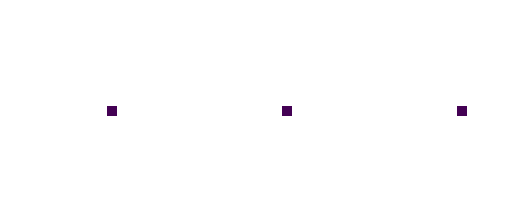

In [10]:
#we are trying to get strings of 3 cells masked out



def get_crop_around_cell(image, instance_mask, cell_id):
    cell1_mask = instance_mask == cell_id+1
    cell1 = ma.masked_array(image, mask=~cell1_mask)
    #crop artoudn tis center
    indices = np.nonzero(cell1)
    center = np.round(np.mean(indices, axis=1)).astype(int)
    crop_size = 20
    top = int(center[0] - crop_size/2)
    bottom = int(center[0] + crop_size/2)
    left = int(center[1] - crop_size/2)
    right = int(center[1] + crop_size/2)

    # crop the array
    cropped_arr = cell1[top:bottom, left:right]
    return cropped_arr

for i in range(1):
    match = merged_pairs[i]

    plt.subplot(1,3,1)
    plt.imshow(get_crop_around_cell(image=images[0], instance_mask=instance_masks[0], cell_id=match[0]))
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(get_crop_around_cell(image=images[1], instance_mask=instance_masks[1], cell_id=match[1]))
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(get_crop_around_cell(image=images[2], instance_mask=instance_masks[2], cell_id=match[2]))
    plt.axis('off')

    plt.show()

In [11]:
print(len(match))

24


24
[ 0 27 28 32 35 38 41]


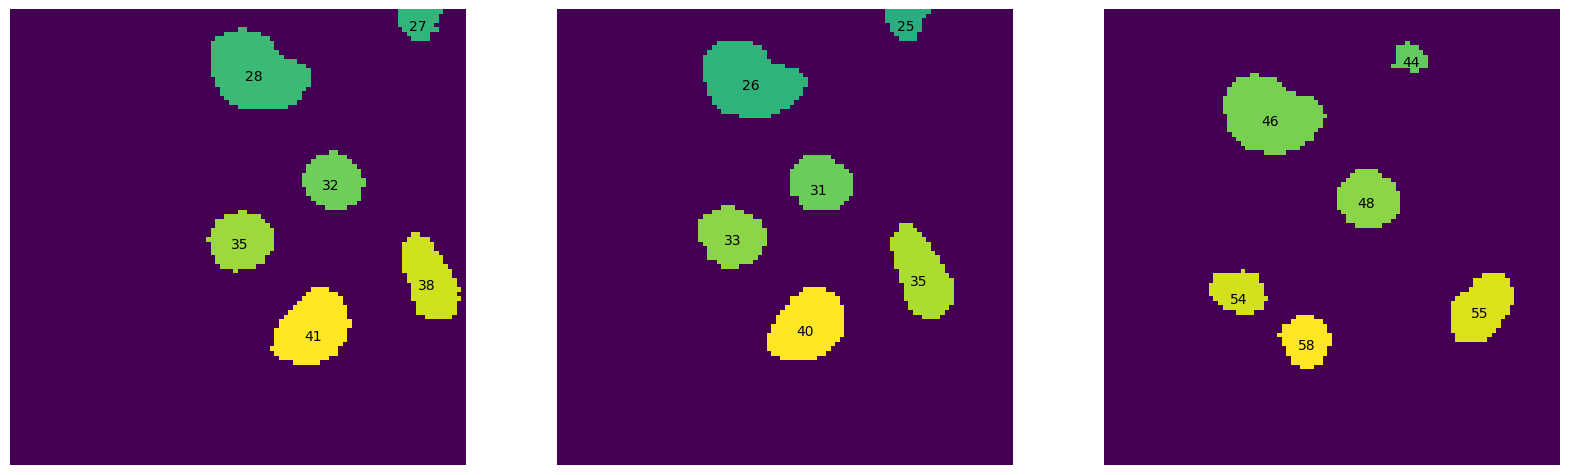

In [44]:
#display a crop around the image, then the mask of that crop, the the cropped out cell
import seaborn as sns

image=images[0]
instance_mask=instance_masks[0]
cp=cps[0]

#for i in range(130):
i = 24
print(i)
cell_id=merged_pairs[i][0]

cell1_mask = instance_mask == cell_id+1
cell1 = ma.masked_array(image, mask=~cell1_mask)
#crop artoudn tis center
indices = np.nonzero(cell1)
center = np.round(np.mean(indices, axis=1)).astype(int)
crop_size = 100
top = int(center[0] - crop_size/2)
bottom = int(center[0] + crop_size/2)
left = int(center[1] - crop_size/2)
right = int(center[1] + crop_size/2)

#plt.subplot(1,3,1)
#cropped_arr_image = image[top:bottom, left:right]
#plt.axis('off')
#plt.imshow(cropped_arr_image)
plt.figure(figsize=(20,12))
plt.subplot(1,3,1)
cropped_arr_im = instance_masks[0][top:bottom, left:right]
print(np.unique(cropped_arr_im))
#for the values in np.unique of cropped_ar_im we find the middle of these values in the mask and display it on them
for val in np.unique(cropped_arr_im):
    if val != 0:
        mask = cropped_arr_im == val
        indices = np.nonzero(mask)
        center = np.round(np.mean(indices, axis=1)).astype(int)
        plt.text(center[1]-2,center[0]+2,str(val), c='black',fontsize=10)
plt.axis('off')
plt.imshow(cropped_arr_im)
#sns.heatmap(cropped_arr_im, annot=True)

plt.subplot(1,3,2)
cropped_arr_im = instance_masks[1][top:bottom, left:right]
for val in np.unique(cropped_arr_im):
    if val != 0:
        mask = cropped_arr_im == val
        indices = np.nonzero(mask)
        center = np.round(np.mean(indices, axis=1)).astype(int)
        plt.text(center[1]-2,center[0]+2,str(val), c='black',fontsize=10)
plt.axis('off')
plt.imshow(cropped_arr_im)

plt.subplot(1,3,3)
cropped_arr_im = instance_masks[2][top:bottom, left:right]
for val in np.unique(cropped_arr_im):
    if val != 0:
        mask = cropped_arr_im == val
        indices = np.nonzero(mask)
        center = np.round(np.mean(indices, axis=1)).astype(int)
        plt.text(center[1]-2,center[0]+2,str(val), c='black',fontsize=10)
plt.axis('off')
plt.imshow(cropped_arr_im)

#plt.subplot(2,1,2)
#instance_mask_binary = np.where(instance_mask != 0, 1, 0)
#cropped_arr = instance_mask_binary[top:bottom, left:right]
#plt.axis('off')
#plt.imshow(cropped_arr)

plt.show()